In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from scipy.signal import savgol_filter

import torch
import numpy as np
import pickle

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Product, ConstantKernel as C

import gym_sin
from gym import spaces

from utilities.arguments import get_args
from learner.posterior_multi_task import PosteriorMTAgent
from learner.posterior_thompson_sampling import PosteriorTSAgent
from learner.postrerior_ts_opt import PosteriorOptTSAgent
from inference.inference_network import InferenceNetwork
from task.GuassianTaskGenerator import GaussianTaskGenerator


In [4]:

def get_const_task_sequence(alpha, n_restarts, num_test_processes, std):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    init_prior_test = [torch.tensor([[-10], [5]], dtype=torch.float32) for _ in range(num_test_processes)]

    mean = -5

    prior_seq = []
    for idx in range(15):
        prior_seq.append(torch.tensor([[mean], [std]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_linear_task_sequence(alpha, n_restarts, num_test_processes, std):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    init_prior_test = [torch.tensor([[30], [5]], dtype=torch.float32) for _ in range(num_test_processes)]

    prior_seq = []
    for idx in range(20):
        mean = 30 - idx

        prior_seq.append(torch.tensor([[mean], [std]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_phase_task_sequence(alpha, n_restarts, num_test_processes, std):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    init_prior_test = [torch.tensor([[-5], [5]], dtype=torch.float32) for _ in range(num_test_processes)]

    prior_seq = []
    for idx in range(40):
        if idx < 15:
            mean = 0
        elif idx < 30:
            mean = 10
        else:
            mean = 0

        prior_seq.append(torch.tensor([[mean], [std]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


def get_abrupt_and_smooth(alpha, n_restarts, num_test_processes, std):
    kernel = C(1.0, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5))

    gp_list = []
    for i in range(num_test_processes):
        gp_list.append([GaussianProcessRegressor(kernel=kernel,
                                                 alpha=alpha ** 2,
                                                 normalize_y=True,
                                                 n_restarts_optimizer=n_restarts)
                        for _ in range(num_test_processes)])
    init_prior_test = [torch.tensor([[-30], [5]], dtype=torch.float32) for _ in range(num_test_processes)]
    prior_seq = []

    for idx in range(60):
        if idx < 15:
            mean = -30
        elif idx < 50:
            mean = -20 + (idx - 15)
        else:
            mean = -20 + 50 - 15

        prior_seq.append(torch.tensor([[mean], [std]], dtype=torch.float32))

    return gp_list, prior_seq, init_prior_test


In [5]:
env_name = "gauss-v0"

action_space = spaces.Box(low=np.array([-1]), high=np.array([1]))
latent_dim = 1

x_min = -100
x_max = 100

min_mean = -60
max_mean = 60

prior_mu_min = -10
prior_mu_max = 10
prior_std_min = 1
prior_std_max = 10

std = 5
amplitude=1

device = "cpu"

task_generator = GaussianTaskGenerator(x_min, x_max, min_mean, max_mean,
                 prior_mu_min, prior_mu_max, prior_std_min, prior_std_max, std, amplitude)
fam = task_generator.create_task_family(n_tasks=5000, n_batches=1, test_perc=0, batch_size=1)

In [6]:
def view_tracking_ts(folder, gp_list, prior_seq, init_prior, sw_size, env_name, seed, log_dir, use_env_obs, num_eval_proc,
                  task_generator):
    dirs_containing_res = os.listdir(folder)
    vi_list = []
    for d in dirs_containing_res:
        vi_list.append(torch.load(folder + d + "/vi"))
        
    eval_true_sigma_list = []
    posterior_history_true_sigma_list = []
    prediction_mean_true_sigma_list = []

    eval_false_sigma_list = []
    posterior_history_false_sigma_list = []
    prediction_mean_false_sigma_list = []

    eval_prior = []

    for vi in vi_list:
        agent = PosteriorTSAgent(vi=None,
                                 vi_optim=None,
                                 num_steps=100,
                                 num_processes=32,
                                 device="cpu",
                                 gamma=1,
                                 latent_dim=1,
                                 use_env_obs=False,
                                 min_action=-100,
                                 max_action=100,
                                 max_sigma=10,
                                 use_decay_kld=True,
                                 decay_kld=0
                                 )
        
        agent.vi = vi

        envs_args = [task_generator.sample_task_from_prior(prior_seq[i]) for i in range(len(prior_seq))]
        eval_episode, posterior_history, prediction_mean = agent.test_task_sequence(gp_list=gp_list,
                                                                                    sw_size=10, 
                                                                                    env_name='gauss-v0', 
                                                                                    seed=0, 
                                                                                    log_dir=".",
                                                                                    envs_kwargs_list=envs_args, 
                                                                                    init_prior=init_prior,
                                                                                    num_eval_processes=1,
                                                                                    use_true_sigma=True,
                                                                                    use_real_prior=False,
                                                                                    true_prior_sequence=None)
        eval_true_sigma_list.append(eval_episode)
        posterior_history_true_sigma_list.append(posterior_history)
        prediction_mean_true_sigma_list.append(prediction_mean)
    
        eval_episode, posterior_history, prediction_mean = agent.test_task_sequence(gp_list=gp_list,
                                                                                    sw_size=10, 
                                                                                    env_name='gauss-v0', 
                                                                                    seed=0, 
                                                                                    log_dir=".",
                                                                                    envs_kwargs_list=envs_args, 
                                                                                    init_prior=init_prior,
                                                                                    num_eval_processes=1,
                                                                                    use_true_sigma=False,
                                                                                    use_real_prior=False,
                                                                                    true_prior_sequence=None)

        eval_false_sigma_list.append(eval_episode)
        posterior_history_false_sigma_list.append(posterior_history)
        prediction_mean_false_sigma_list.append(prediction_mean)

        eval_episode, _, _ = agent.test_task_sequence(gp_list=gp_list,
                                                                                    sw_size=10, 
                                                                                    env_name='gauss-v0', 
                                                                                    seed=0, 
                                                                                    log_dir=".",
                                                                                    envs_kwargs_list=envs_args, 
                                                                                    init_prior=init_prior,
                                                                                    num_eval_processes=1,
                                                                                    use_true_sigma=False,
                                                                                    use_real_prior=True,
                                                                                    true_prior_sequence=prior_seq)

        eval_prior.append(eval_episode)
    
    seq_len = len(prior_seq)
    x = np.arange(seq_len)

    #eval_true_sigma_list = np.array(eval_true_sigma_list)
    m = np.mean(eval_true_sigma_list, 0)
    std = np.std(eval_true_sigma_list, 0)
    plt.plot(x, m, label="True sigma")
    plt.fill_between(x, m - std, m + std, alpha=0.2)

    #eval_false_sigma_list = np.array(eval_false_sigma_list)
    m = np.mean(eval_false_sigma_list, 0)
    std = np.std(eval_false_sigma_list, 0)
    plt.plot(x, m, label="False sigma")
    plt.fill_between(x, m - std, m + std, alpha=0.2)

    #eval_prior = np.array(eval_prior)
    m = np.mean(eval_prior, 0)
    std = np.std(eval_prior, 0)
    plt.plot(x, m, label="True prior")
    plt.fill_between(x, m - std, m + std, alpha=0.2)

    plt.legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.plot()
    plt.show()
    
    history_true_sigma = []
    for proc in range(8):
        curr_h = []
        for t_idx in range(seq_len):
            curr_h.append(posterior_history_true_sigma_list[proc][t_idx][0,0].item())
        history_true_sigma.append(curr_h)

    prediction_mean_true_sigma_list = np.array(prediction_mean_true_sigma_list)
    
    history_false_sigma = []
    for proc in range(8):
        curr_h = []
        for t_idx in range(seq_len):
            curr_h.append(posterior_history_false_sigma_list[proc][t_idx][0,0].item())
        history_false_sigma.append(curr_h)

    prediction_mean_false_sigma_list = np.array(prediction_mean_false_sigma_list)
    
    m = np.mean(prediction_mean_true_sigma_list, 0)
    std = np.mean(prediction_mean_true_sigma_list, 0)
    plt.plot(x, m, label="GP Pred True sigma")
    plt.fill_between(x, m - std, m + std, alpha=0.2)

    m = np.mean(history_true_sigma, 0)
    std = np.mean(history_true_sigma, 0)
    plt.plot(x, m, label="Posterior True")
    plt.fill_between(x, m - std, m + std, alpha=0.2)

    m = np.mean(prediction_mean_false_sigma_list, 0)
    std = np.mean(prediction_mean_false_sigma_list, 0)
    plt.plot(x, m, label="GP Pred False sigma")
    plt.fill_between(x, m - std, m + std, alpha=0.2)

    m = np.mean(history_false_sigma, 0)
    std = np.mean(history_false_sigma, 0)
    plt.plot(x, m, label="Posterior False")
    plt.fill_between(x, m - std, m + std, alpha=0.2)

    t = [prior_seq[i][0].item() for i in range(seq_len)]
    plt.plot(x, t, label="True task")

    plt.legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.plot()

Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...


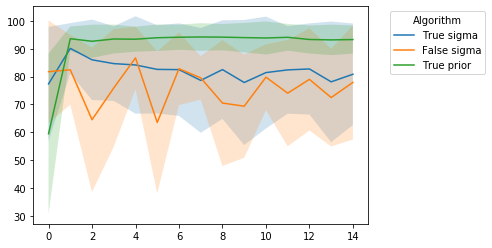

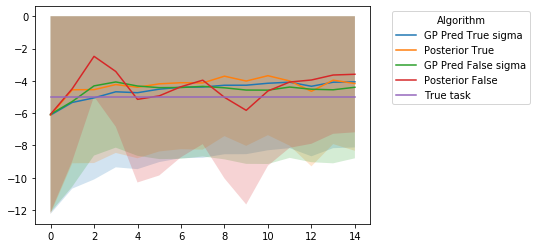

In [7]:
gp_list, prior_seq, init_prior = get_const_task_sequence(0.25, 1, 1, 0.1)
folder = "../result/newnewnew/tspostkdl10/"
view_tracking_ts(folder, gp_list, prior_seq, init_prior, 10, 
              "gauss-v0", 0, ".", False, 1,
              task_generator)

Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...


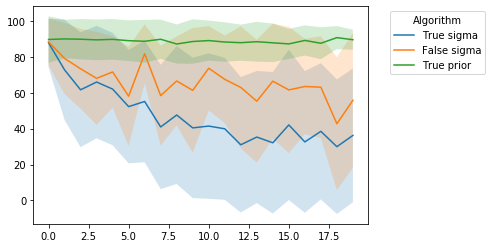

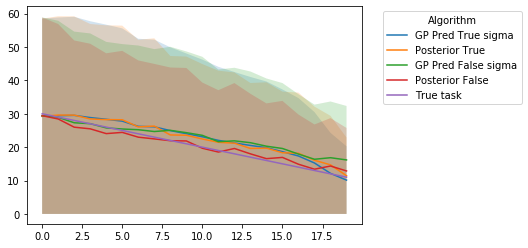

In [8]:
gp_list, prior_seq, init_prior = get_linear_task_sequence(0.25, 1, 1, 0.1)
folder = "../result/newnewnew/tspostkdl10/"
view_tracking_ts(folder, gp_list, prior_seq, init_prior, 10, 
              "gauss-v0", 0, ".", False, 1,
              task_generator)

Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...


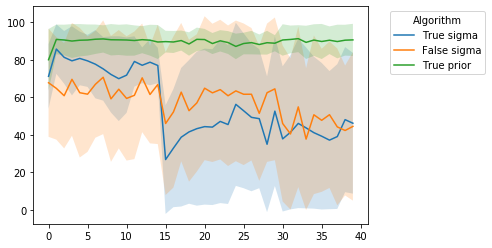

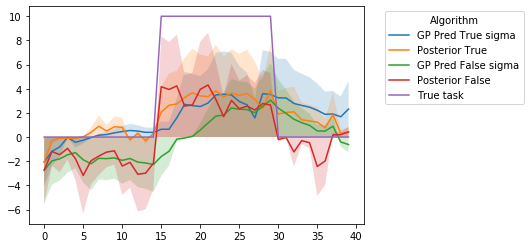

In [9]:
gp_list, prior_seq, init_prior = get_phase_task_sequence(0.25, 1, 1, 0.1)
folder = "../result/newnewnew/tspostkdl10/"
view_tracking_ts(folder, gp_list, prior_seq, init_prior, 10, 
              "gauss-v0", 0, ".", False, 1,
              task_generator)

Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...


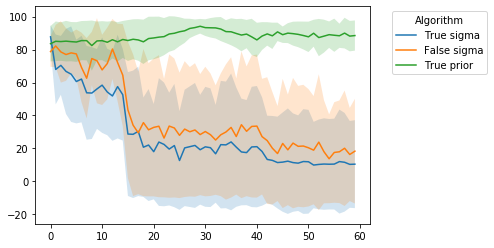

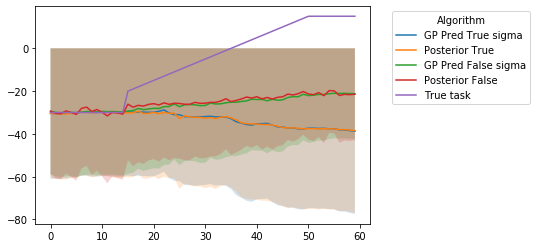

In [10]:
gp_list, prior_seq, init_prior = get_abrupt_and_smooth(0.25, 1, 1, 0.1)
folder = "../result/newnewnew/tspostkdl10/"
view_tracking_ts(folder, gp_list, prior_seq, init_prior, 10, 
              "gauss-v0", 0, ".", False, 1,
              task_generator)

In [35]:
def view_tracking_ts_opt(folder, gp_list, prior_seq, init_prior, sw_size, env_name, seed, log_dir, use_env_obs, num_eval_proc,
                  task_generator):
    dirs_containing_res = os.listdir(folder)
    vi_list = []
    model_list = []
    for d in dirs_containing_res:
        vi_list.append(torch.load(folder + d + "/agent_vi"))
        model_list.append(torch.load(folder + d + "/agent_ac"))
        
    eval_true_sigma_list = []
    posterior_history_true_sigma_list = []
    prediction_mean_true_sigma_list = []

    eval_false_sigma_list = []
    posterior_history_false_sigma_list = []
    prediction_mean_false_sigma_list = []

    eval_prior = []

    for vi, model in zip(vi_list, model_list):
        max_old = [100]
        min_old = [-100]
        agent = PosteriorOptTSAgent(vi=None,
                                    vi_optim=None,
                                    num_steps=100,
                                    num_processes=32,
                                    device="cpu",
                                    gamma=1,
                                    latent_dim=1,
                                    use_env_obs=False,
                                    min_action=-100,
                                    max_action=100,
                                    max_sigma=10,
                                    action_space=spaces.Box(low=np.array([-1]), high=np.array([1])),
                                    obs_shape=(1,),
                                    clip_param=0.1,
                                    ppo_epoch=4,
                                    num_mini_batch=8,
                                    value_loss_coef=0.5,
                                    entropy_coef=0.,
                                    lr=0.00005,
                                    eps=1e-6,
                                    max_grad_norm=0.5,
                                    use_linear_lr_decay=False,
                                    use_gae=False,
                                    gae_lambda=0.98,
                                    use_proper_time_limits=False,
                                    recurrent_policy=False,
                                    hidden_size=8,
                                    use_elu=True,
                                    rescale_obs=True,
                                    max_old=max_old,
                                    min_old=min_old,
                                    use_decay_kld=True,
                                    decay_kld_rate=1)
        
        agent.actor_critic = model
        agent.vi = vi

        envs_args = [task_generator.sample_task_from_prior(prior_seq[i]) for i in range(len(prior_seq))]
        eval_episode, posterior_history, prediction_mean = agent.test_task_sequence(gp_list=gp_list,
                                                                                    sw_size=10, 
                                                                                    env_name='gauss-v0', 
                                                                                    seed=0, 
                                                                                    log_dir=".",
                                                                                    envs_kwargs_list=envs_args, 
                                                                                    init_prior=init_prior,
                                                                                    num_eval_processes=1,
                                                                                    use_true_sigma=True,
                                                                                    use_real_prior=False,
                                                                                    true_prior_sequence=None)
        eval_true_sigma_list.append(eval_episode)
        posterior_history_true_sigma_list.append(posterior_history)
        prediction_mean_true_sigma_list.append(prediction_mean)
    
        eval_episode, posterior_history, prediction_mean = agent.test_task_sequence(gp_list=gp_list,
                                                                                    sw_size=10, 
                                                                                    env_name='gauss-v0', 
                                                                                    seed=0, 
                                                                                    log_dir=".",
                                                                                    envs_kwargs_list=envs_args, 
                                                                                    init_prior=init_prior,
                                                                                    num_eval_processes=1,
                                                                                    use_true_sigma=False,
                                                                                    use_real_prior=False,
                                                                                    true_prior_sequence=None)

        eval_false_sigma_list.append(eval_episode)
        posterior_history_false_sigma_list.append(posterior_history)
        prediction_mean_false_sigma_list.append(prediction_mean)

        eval_episode, _, _ = agent.test_task_sequence(gp_list=gp_list,
                                                                                    sw_size=10, 
                                                                                    env_name='gauss-v0', 
                                                                                    seed=0, 
                                                                                    log_dir=".",
                                                                                    envs_kwargs_list=envs_args, 
                                                                                    init_prior=init_prior,
                                                                                    num_eval_processes=1,
                                                                                    use_true_sigma=False,
                                                                                    use_real_prior=True,
                                                                                    true_prior_sequence=prior_seq)

        eval_prior.append(eval_episode)
    
    seq_len = len(prior_seq)
    x = np.arange(seq_len)

    #eval_true_sigma_list = np.array(eval_true_sigma_list)
    m = np.mean(eval_true_sigma_list, 0)
    std = np.std(eval_true_sigma_list, 0)
    plt.plot(x, m, label="True sigma")
    plt.fill_between(x, m - std, m + std, alpha=0.2)

    #eval_false_sigma_list = np.array(eval_false_sigma_list)
    m = np.mean(eval_false_sigma_list, 0)
    std = np.std(eval_false_sigma_list, 0)
    plt.plot(x, m, label="False sigma")
    plt.fill_between(x, m - std, m + std, alpha=0.2)

    #eval_prior = np.array(eval_prior)
    m = np.mean(eval_prior, 0)
    std = np.std(eval_prior, 0)
    plt.plot(x, m, label="True prior")
    plt.fill_between(x, m - std, m + std, alpha=0.2)

    plt.legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.plot()
    plt.show()
    
    history_true_sigma = []
    for proc in range(8):
        curr_h = []
        for t_idx in range(seq_len):
            curr_h.append(posterior_history_true_sigma_list[proc][t_idx][0,0].item())
        history_true_sigma.append(curr_h)

    prediction_mean_true_sigma_list = np.array(prediction_mean_true_sigma_list)
    
    history_false_sigma = []
    for proc in range(8):
        curr_h = []
        for t_idx in range(seq_len):
            curr_h.append(posterior_history_false_sigma_list[proc][t_idx][0,0].item())
        history_false_sigma.append(curr_h)

    prediction_mean_false_sigma_list = np.array(prediction_mean_false_sigma_list)
    
    m = np.mean(prediction_mean_true_sigma_list, 0)
    std = np.mean(prediction_mean_true_sigma_list, 0)
    plt.plot(x, m, label="GP Pred True sigma")
    plt.fill_between(x, m - std, m + std, alpha=0.2)

    m = np.mean(history_true_sigma, 0)
    std = np.mean(history_true_sigma, 0)
    plt.plot(x, m, label="Posterior True")
    plt.fill_between(x, m - std, m + std, alpha=0.2)

    m = np.mean(prediction_mean_false_sigma_list, 0)
    std = np.mean(prediction_mean_false_sigma_list, 0)
    plt.plot(x, m, label="GP Pred False sigma")
    plt.fill_between(x, m - std, m + std, alpha=0.2)

    m = np.mean(history_false_sigma, 0)
    std = np.mean(history_false_sigma, 0)
    plt.plot(x, m, label="Posterior False")
    plt.fill_between(x, m - std, m + std, alpha=0.2)

    t = [prior_seq[i][0].item() for i in range(seq_len)]
    plt.plot(x, t, label="True task")

    plt.legend(title='Algorithm', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.plot()

Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...
Meta-testing...


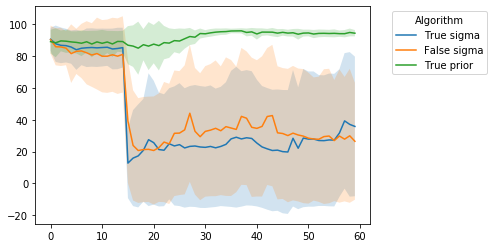

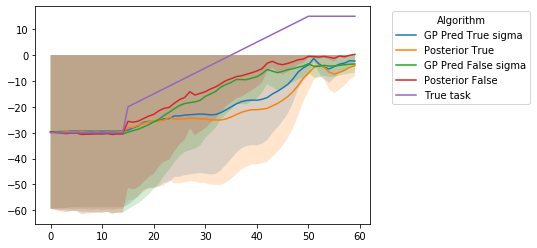

In [36]:
gp_list, prior_seq, init_prior = get_abrupt_and_smooth(0.25, 1, 1, 0.1)
folder = "../result/newnewgaussv0/tsoptupd/"
view_tracking_ts_opt(folder, gp_list, prior_seq, init_prior, 10, 
              "gauss-v0", 0, ".", False, 1,
              task_generator)

In [19]:
torch.normal(torch.tensor([5.]),torch.tensor([-100.]))

tensor([219.0954])